## Branch prediction

In [1]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np

In [5]:
predictors = ['bimodal', 'markov', 'stochastic']

def get_stats(stat_file):
    with open(stat_file, 'r') as file:
        json_data = json.load(file)
        stats = json_data[0]["roi"]["cores"][0]
        name = json_data[0]['traces'][0].split('/')[-1]
    ipc = stats["instructions"] / stats["cycles"]
    mpki = stats['mispredict']['BRANCH_CONDITIONAL'] / stats["instructions"] * 10**3
    return ipc, mpki, name

results = {}
for pred in predictors:
    results[pred] = {}
    for stat_file in os.listdir(pred):
        stat_path = os.path.join(pred, stat_file)
        ipc, mpki, name = get_stats(stat_path)
        results[pred][name] = {'ipc' : ipc, 'mpki' : mpki}

In [6]:
def geomean(data):
    return np.power(np.prod(np.array(data)), 1 / len(data))

for pred in predictors:
    ipc = []
    mpki = []
    for (_, metrics) in results[pred].items():
        ipc.append(metrics['ipc'])
        mpki.append(metrics['mpki'])
    ipc_gmean = geomean(ipc)
    mpki_gmean = geomean(mpki)
    print(f'{pred}\n\tIPC : {ipc_gmean}\n\tMPKI : {mpki_gmean}')

bimodal
	IPC : 1.1746013523417302
	MPKI : 2.3657037770665124
markov
	IPC : 1.3001769495961695
	MPKI : 1.7610218098602561
stochastic
	IPC : 1.2018707084794091
	MPKI : 2.124059883538507


В среднем Markov predictor предсказывает лучше чем бимодальный. Вероятностная реализация работает лучше бимодального, но проигрывает детерминированной

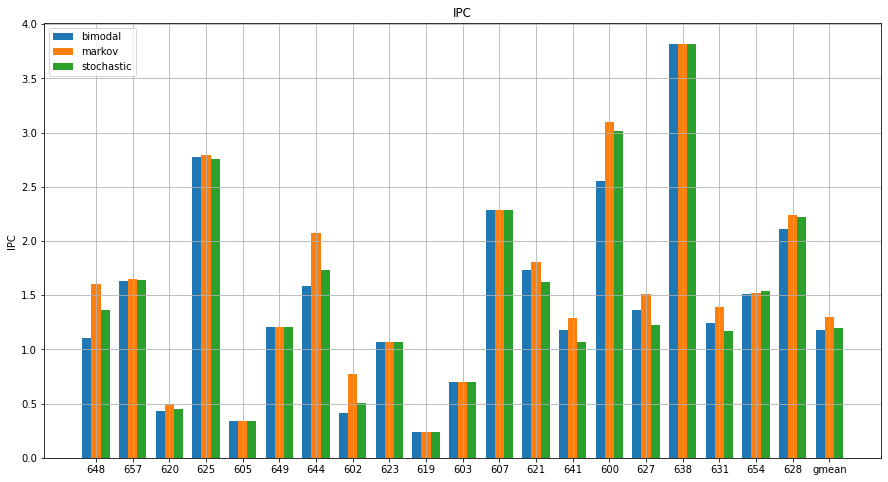

In [7]:
benches = list(results[predictors[0]])
pred_ipc = {}
for pred, metrics in results.items():
    pred_ipc[pred] = []
    for bench in benches:
        pred_ipc[pred].append(results[pred][bench]['ipc'])
benches.append('gmean')
for pred in pred_ipc:
    gmean = geomean(pred_ipc[pred])
    pred_ipc[pred].append(gmean)

fig, ax =  plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
ax.grid()
x = np.arange(len(benches))
width = 0.25  # the width of the bars
multiplier = 0

for pred, ipc in pred_ipc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, ipc, width, label=pred)
    multiplier += 1

ax.set_ylabel('IPC')
ax.set_title('IPC')
ax.set_xticks(x + width, list(map(lambda b : b.split('.')[0], benches)))
ax.legend(loc='upper left')

plt.show()

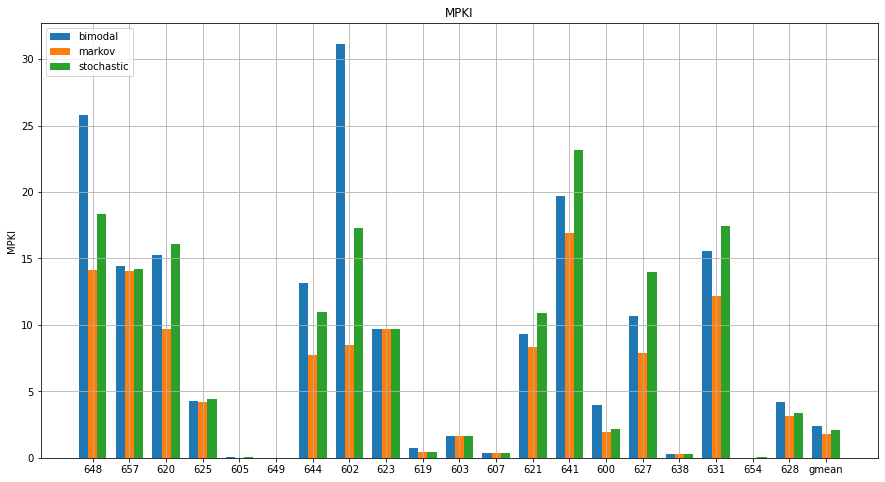

In [8]:
benches = list(results[predictors[0]])
pred_ipc = {}
for pred, metrics in results.items():
    pred_ipc[pred] = []
    for bench in benches:
        pred_ipc[pred].append(results[pred][bench]['mpki'])
benches.append('gmean')
for pred in pred_ipc:
    gmean = geomean(pred_ipc[pred])
    pred_ipc[pred].append(gmean)

fig, ax =  plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(8)
ax.grid()
x = np.arange(len(benches))
width = 0.25  # the width of the bars
multiplier = 0

for pred, ipc in pred_ipc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, ipc, width, label=pred)
    multiplier += 1

ax.set_ylabel('MPKI')
ax.set_title('MPKI')
ax.set_xticks(x + width, list(map(lambda b : b.split('.')[0], benches)))
ax.legend(loc='upper left')

plt.show()

# Conclusions
На диаграммах представлены IPC и MPKI, полученне на каждом бенчмарке при использовании трех предсказателей, а также геометрическое среднее по всем бенчмаркам.

Видно что Markov predictor показывает результаты лучше бимодального на всех бенчмарках, а не только в среднем.

Для бенчмарков, в производительность которых вносит существенный вклад предсказание переходов (бенчмарки с относительно большим MPKI), видна обратная корреляция IPC и MPKI (600, 602, 627, 641).

Исключением является SPEC 654. Вероятностная реализация получила наибольший IPC при наибольшем MPKI. Это вероятно связано с наличием сложных для предсказания (probability 50%) переходов в наиболее горячей части бенчмарка.